In [1]:
# from IPython.core.display import display,HTML
# display(HTML('<style> div.prompt {display:default} </style>'))

In [1]:
import os, importlib, sys, time, h5py

In [2]:
import numpy as np
from scipy import linalg, stats, ndimage, io
from scipy.sparse import diags

In [3]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'], 'size':13})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
import ladyns as ldn
import ladyns.inference as inf
import ladyns.optimize.core as core

In [5]:
importlib.reload(ldn)
importlib.reload(inf)
importlib.reload(core)

<module 'ladyns.optimize.core' from '/home/hbong/miniconda3/lib/python3.7/site-packages/ladyns/optimize/core.cpython-37m-x86_64-linux-gnu.so'>

# 0. Load data

In [6]:
data_dir = "../data"
file_name = ['lfp_bred_1.mat', 'lfp_bred_2.mat', 'lfp_bred_3.mat']
rec_time = [0, 0.5]

In [7]:
data = [
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['v4_bred']
                    for fname in file_name], 0)[:,:,:100:2].T,
    np.concatenate([io.loadmat('%s/%s'%(data_dir, fname))['pfc_bred']
                    for fname in file_name], 0)[:,:,:100:2].T]

In [8]:
data[0].shape, data[1].shape

((50, 25, 3000), (50, 25, 3000))

In [14]:
dims = [data[0].shape[1], data[1].shape[1]]
num_time = data[0].shape[0]
num_trial = data[0].shape[2]

# 1. parameter calibration

In [10]:
offset_cross=10
offset_auto=10
lambdas= np.vstack([
    np.exp(np.linspace(np.log(0.1), np.log(0.001), 11)), #np.full((11,), 0.06), ## lambdas_cross
    np.zeros(11), ## lambdas_auto
    np.full((11,), 0.5), ## lambdas_diag
    np.zeros(11)]) ## lambdas_ridge

In [11]:
time_graph_cross = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross)
time_graph_auto = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_auto)

## calibration by permutation

In [12]:
num_cv = 10

In [16]:
Omegas_cv = np.zeros([num_cv, lambdas.shape[-1], 2*num_time, 2*num_time])
weights_cv = []

for iter_cv in np.arange(num_cv):
    start_cv = time.time()
    
    # random sample
    trial_sample = np.random.choice(num_trial, num_trial, False)
    data_bst = [data[0], data[1][:,:,trial_sample]]

    for iter_est, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
    in enumerate(zip(*lambdas)): 
        if iter_cv > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est],
                        'weight_init': weights_cv[iter_est]}
        elif iter_est > 0:
            init_arg = {'Omega_init': Omegas_cv[0,iter_est-1],
                        'weight_init': weights_cv[iter_est-1]}
        else:
            init_arg = dict()

        Omega_est, Sigma_est, latent_est, weight_est \
        = ldn.fit(data_bst, lambda_diag, lambda_cross, offset_cross,
                   lambda_auto, offset_auto, 
                   ths_glasso=1e-6, ths_lasso=1e-6, verbose=True,
                   **init_arg)
        
        # save result
        Omegas_cv[iter_cv, iter_est] = Omega_est
        if iter_cv == 0:
            weights_cv.append(weight_est)

    sys.__stdout__.write("%d-th cv finished, lapse: %.3fsec.\n"
                         %(iter_cv+1, time.time()-start_cv))
    sys.__stdout__.flush()

1-th iter, nll: 67.675621, change: 0.097901, lapse: 0.490762
2-th iter, nll: 67.595802, change: 0.009610, lapse: 0.466719
3-th iter, nll: 67.532208, change: 0.006338, lapse: 0.457017
4-th iter, nll: 67.479300, change: 0.005463, lapse: 0.444379
5-th iter, nll: 67.434212, change: 0.004936, lapse: 0.467529
6-th iter, nll: 67.395191, change: 0.004582, lapse: 0.441321
7-th iter, nll: 67.361042, change: 0.004318, lapse: 0.431388
8-th iter, nll: 67.330908, change: 0.004081, lapse: 0.420522
9-th iter, nll: 67.304145, change: 0.003854, lapse: 0.403874
10-th iter, nll: 67.280253, change: 0.003635, lapse: 0.401167
11-th iter, nll: 67.258832, change: 0.003424, lapse: 0.395791
12-th iter, nll: 67.239557, change: 0.003224, lapse: 0.397429
13-th iter, nll: 67.222158, change: 0.003042, lapse: 0.446156
14-th iter, nll: 67.206409, change: 0.002884, lapse: 0.460013
15-th iter, nll: 67.192117, change: 0.002733, lapse: 0.387981
16-th iter, nll: 67.179120, change: 0.002589, lapse: 0.391730
17-th iter, nll: 

1-th iter, nll: 67.055466, change: 0.000948, lapse: 0.323193
1-th iter, nll: 67.053398, change: 0.000913, lapse: 0.322923
1-th iter, nll: 67.051253, change: 0.017785, lapse: 0.326607
2-th iter, nll: 67.049451, change: 0.000849, lapse: 0.321344
1-th iter, nll: 67.047146, change: 0.033389, lapse: 0.319031
2-th iter, nll: 67.045570, change: 0.000789, lapse: 0.322467
1-th iter, nll: 67.043043, change: 0.044415, lapse: 0.344476
2-th iter, nll: 67.041658, change: 0.000734, lapse: 0.316064
1-th iter, nll: 67.039098, change: 0.052791, lapse: 0.348523
2-th iter, nll: 67.037880, change: 0.000686, lapse: 0.342504
1-th iter, nll: 67.035417, change: 0.058341, lapse: 0.346699
2-th iter, nll: 67.034340, change: 0.000644, lapse: 0.321895
1-th iter, nll: 67.032159, change: 0.060818, lapse: 0.347769
2-th iter, nll: 67.031203, change: 0.000608, lapse: 0.302498
1-th iter, nll: 67.029369, change: 0.062658, lapse: 0.365032
2-th iter, nll: 67.028516, change: 0.000579, lapse: 0.302122
1-th iter, nll: 67.02702

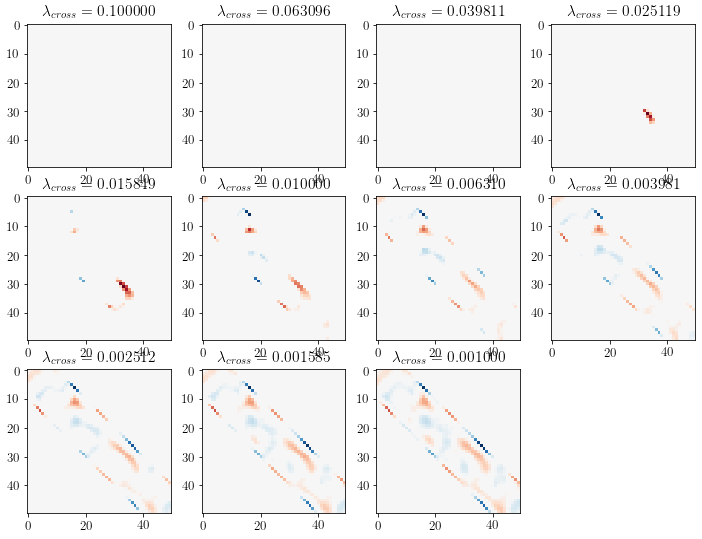

In [17]:
plt.figure(figsize=(12,3*np.ceil(lambdas.shape[-1]/4)))
for iter_lambda, (lambda_cross, lambda_auto, lambda_diag, lambda_ridge) \
in enumerate(zip(*lambdas)):
    plt.subplot(np.ceil(lambdas.shape[-1]/4), 4, iter_lambda+1)
    ldn.imshow(Omegas_cv[0, iter_lambda,:num_time,num_time:], identity=True)
    plt.title(r'$\lambda_{cross} = %f$'%lambda_cross)

In [18]:
fds_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/num_cv
fdrs_cv = np.sum(Omegas_cv[:,:,:num_time,num_time:]!=0,(0,-2,-1))/np.sum(time_graph_cross)/num_cv

Text(0, 0.5, 'mean false discovery')

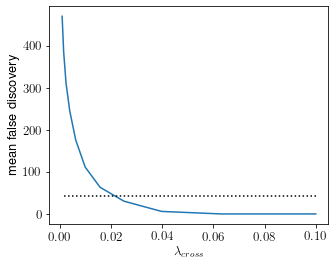

In [19]:
plt.figure(figsize=(5,4))
plt.plot(lambdas[0], fds_cv)
plt.plot(lambdas[0], np.full(lambdas[0].shape, 0.05*np.sum(time_graph_cross)), color='black', linestyle=':')
plt.xlabel(r"$\lambda_{cross}$")
plt.ylabel(r"mean false discovery")

# cv result

In [20]:
id_cv = np.argmax(fdrs_cv[fdrs_cv < 0.05])

In [21]:
lambda_cross, lambda_auto, lambda_diag, lambda_ridge = lambdas.T[id_cv]
lambda_cross, lambda_auto, lambda_diag, lambda_ridge

(0.025118864315095805, 0.0, 0.5, 0.0)

## LaDynS estimate

In [16]:
Omega_est, Sigma_est, latent_est, weight_est \
= ldn.fit(data, lambda_diag, lambda_cross, offset_cross,
           lambda_auto, offset_auto, 
           ths_glasso=1e-6, ths_lasso=1e-6, verbose=True)

1-th iter, nll: 67.671307, change: 0.097901, lapse: 0.601090
2-th iter, nll: 67.591409, change: 0.009539, lapse: 0.569860
3-th iter, nll: 67.527741, change: 0.006285, lapse: 0.715627
4-th iter, nll: 67.474768, change: 0.005465, lapse: 0.542899
5-th iter, nll: 67.429632, change: 0.004933, lapse: 0.531161
6-th iter, nll: 67.390578, change: 0.004577, lapse: 0.527145
7-th iter, nll: 67.356413, change: 0.004311, lapse: 0.559462
8-th iter, nll: 67.326277, change: 0.004072, lapse: 0.503991
9-th iter, nll: 67.299524, change: 0.003844, lapse: 0.551614
10-th iter, nll: 67.275652, change: 0.003624, lapse: 0.486654
11-th iter, nll: 67.254259, change: 0.003414, lapse: 0.487320
12-th iter, nll: 67.235018, change: 0.003213, lapse: 0.474926
13-th iter, nll: 67.217657, change: 0.003030, lapse: 0.488309
14-th iter, nll: 67.201949, change: 0.002873, lapse: 0.478708
15-th iter, nll: 67.187700, change: 0.002722, lapse: 0.472510
16-th iter, nll: 67.174747, change: 0.002579, lapse: 0.472023
17-th iter, nll: 

In [202]:
# np.savez('result_exp.npz',
#          Omega_est = Omega_est, Sigma_est = Sigma_est,
#          latent_est = latent_est, weight_est = weight_est)

In [28]:
roi = (np.abs(np.subtract(*np.where(
    np.full([num_time,num_time],True)))
       .reshape([num_time,num_time])) < offset_cross-1)

In [34]:
dspr_est = 2*Omega_est - Omega_est @ Sigma_est @ Omega_est

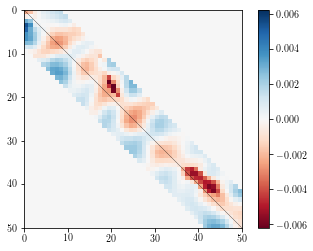

In [36]:
ldn.imshow(dspr_est[:num_time,num_time:] * roi, time=[0, 50], identity=True)
plt.colorbar()

In [37]:
np.max(np.abs(dspr_est[:num_time,num_time:])*roi)

0.006202517694265846

# 1. Key statistics

## auto-correlation

In [18]:
sighat = Sigma_est.copy()
sighat_1 = sighat[:num_time,:num_time]
sighat_2 = sighat[num_time:,num_time:]

In [19]:
Y_mm_1 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_1[np.arange(1,num_time), np.arange(0,num_time-1)])))])
Y_mm_2 = np.concatenate([[0], np.cumsum(np.sqrt(-2*np.log(
    sighat_2[np.arange(1,num_time), np.arange(0,num_time-1)])))])

In [20]:
sigmm_1 = np.exp(-(np.square(Y_mm_1[:,None] - Y_mm_1[None,:])/2))
sigmm_2 = np.exp(-(np.square(Y_mm_2[:,None] - Y_mm_2[None,:])/2))

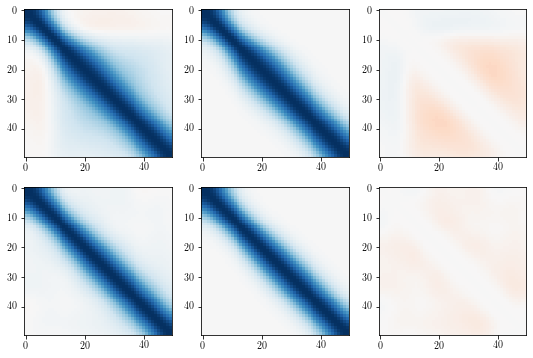

In [21]:
%matplotlib inline
plt.figure(figsize=(9,6))
plt.subplot(2,3,1); ldn.imshow(sighat_1, vmax=1)
plt.subplot(2,3,2); ldn.imshow(sigmm_1, vmax=1)
plt.subplot(2,3,3); ldn.imshow(sigmm_1 - sighat_1, vmax=1)
plt.subplot(2,3,4); ldn.imshow(sighat_2, vmax=1)
plt.subplot(2,3,5); ldn.imshow(sigmm_2, vmax=1)
plt.subplot(2,3,6); ldn.imshow(sigmm_2 - sighat_2, vmax=1)

In [22]:
Y_mm_1[-1]/(num_time-1), Y_mm_2[-1]/(num_time-1)

(0.14842451792365774, 0.16333313075591857)

## cross-correlation

In [26]:
np.max(Sigma_est[:num_time,num_time:])

0.0944295398057583

# 2. simulation 

## cross precision

In [50]:
num_blobs = 3

In [51]:
times = np.array([[1, 1, 12], [22, 22, 6], [33, 33, 9]])

In [142]:
H0 = np.zeros((times.shape[0], num_time, num_time))
for i, (time_0, time_1, duration) in enumerate(times):
    H0[i, time_0:time_0+duration, time_1:time_1+duration] \
    = np.abs(np.arange(duration)-np.arange(duration)[:,None]) < 2

(0.0, 1.0, 0.0, 1.0)

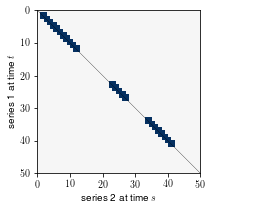

In [143]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(4,3))
gridspec.GridSpec(1,4); plt.subplot2grid((1,4), (0,0), colspan=3, rowspan=1)
ldn.imshow(np.sum(H0, 0), time=[0,50], identity=True, vmax=1)
plt.ylabel(r'series 1 at time $t$'); plt.xlabel(r'series 2 at time $s$')
ax = plt.subplot2grid((1,4), (0,3))
ax.axis('off')

## latent direction

In [258]:
mu = [np.mean(dat, -1) for dat in data]
covs = [
    np.matmul(dat - m[...,None], dat - m[...,None], axes=[(1,2),(2,1),(1,2)])/obs_trial
    for dat, m in zip(data, mu)]

In [259]:
weights_est = [np.array(weight_est[:num_time]),
               np.array(weight_est[num_time:])]

In [260]:
betas_est = [(cov @ w[...,None])[...,0] for cov ,w in zip(covs, weights_est)]

## latent precision

In [261]:
precs_auto = [linalg.inv(S + lambda_diag * np.eye(num_time))
              for S in [sigmm_1, sigmm_2]] 

In [262]:
snr = 0.006
prec_latent = np.array(np.block([
    [precs_auto[0], -snr*np.sum(H0,0)],
    [-snr*np.sum(H0,0).T, precs_auto[1]]
]))
cov_latent = linalg.inv(prec_latent)

In [263]:
cov_latent = cov_latent + (np.min(linalg.eig(Sigma_est)[0]) - np.min(linalg.eig(cov_latent)[0]))*np.eye(2*num_time)
sd_latent = np.sqrt(np.diag(cov_latent))
corr_latent = cov_latent / sd_latent / sd_latent[:,None]
chol_latent = linalg.cholesky(corr_latent)

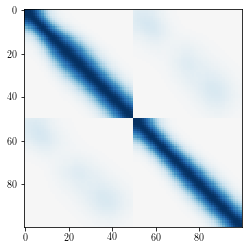

In [264]:
ldn.imshow(corr_latent)

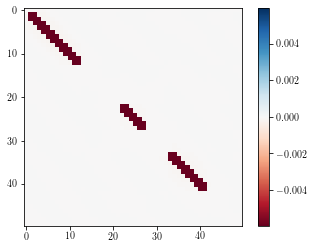

In [265]:
ldn.imshow(np.linalg.inv(corr_latent + lambda_diag*np.eye(2*num_time))[:num_time,num_time:]); plt.colorbar()

In [266]:
# corr_latent[:num_time, num_time:] = corr_latent[:num_time, num_time:].copy()*0.5
# corr_latent[num_time:, :num_time] = corr_latent[num_time:, :num_time].copy()*0.5
# chol_latent = linalg.cholesky(corr_latent)

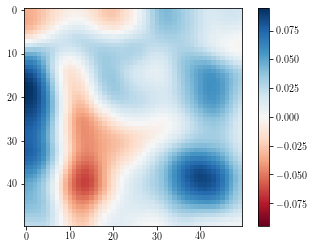

In [267]:
ldn.imshow(Sigma_est[:num_time,num_time:]); plt.colorbar()

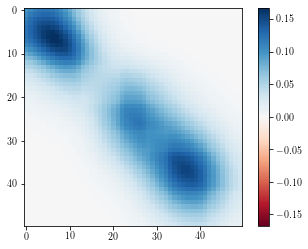

In [268]:
ldn.imshow(corr_latent[:num_time,num_time:]); plt.colorbar()

## simulate

In [269]:
obs_trial = data[0].shape[2]
num_trial = 3000

In [270]:
dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=False)]
         for dat, dim in zip(data, dims)]
ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
          for dir_i, dumm in zip(weights_est, dummy)]

# cov_ldummy = np.cov(ldummy[0], ldummy[1])
# sd_ldummy = np.sqrt(np.diag(cov_ldummy))

latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

pops = [dummy[0] + betas_est[0][:,:,None] * (latent_variables[:num_time,None,:]-ldummy[0][:,None,:]),
        dummy[1] + betas_est[1][:,:,None] * (latent_variables[num_time:,None,:]-ldummy[1][:,None,:])]

In [273]:
# mchols = [np.array([linalg.cholesky(0.5*np.cov(dat_t, bias=True)) for dat_t in dat])
#           for dat in data]

# dummy = [dat[:,:,np.random.choice(obs_trial, num_trial, replace=True)]
#          + np.matmul(mchol.transpose([0,2,1]), np.random.normal(size=(num_time,dim,num_trial)))
#          for dat, dim, mchol in zip(data, dims, mchols)]
# ldummy = [np.squeeze(np.matmul(dir_i[:,None,:], dumm - np.mean(dumm, -1, keepdims=True)))
#           for dir_i, dumm in zip(weights_est, dummy)]

# cov_ldummy = np.cov(ldummy[0], ldummy[1])
# sd_ldummy = np.sqrt(np.diag(cov_ldummy))

# latent_variables = (chol_latent.T @ np.random.normal(0, 1, (2*num_time, num_trial)))

# pops = [dummy[0] + betas_est[0][:,:,None] * (sd_ldummy[:num_time,None,None]*latent_variables[:num_time,None,:]-ldummy[0][:,None,:]),
#         dummy[1] + betas_est[1][:,:,None] * (sd_ldummy[num_time:,None,None]*latent_variables[num_time:,None,:]-ldummy[1][:,None,:])]

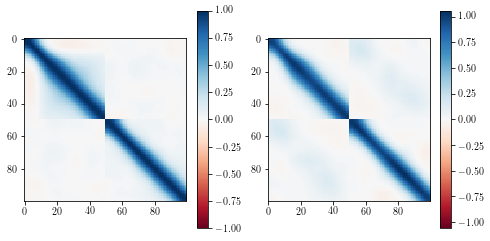

In [274]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); ldn.imshow(np.cov(ldummy[0],ldummy[1], bias=True)); plt.colorbar()
plt.subplot(1,2,2); ldn.imshow(np.cov(latent_variables, bias=True)); plt.colorbar()

In [276]:
np.linalg.slogdet(np.corrcoef(ldummy[0],ldummy[1]))

(1.0, -740.0751334589147)

In [277]:
np.linalg.slogdet(np.corrcoef(latent_variables))

((1-0j), -472.59623094920755)

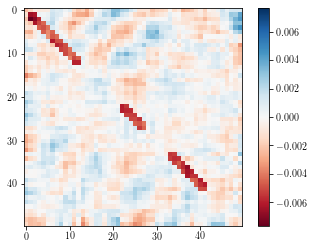

In [278]:
ldn.imshow(linalg.inv(np.corrcoef(latent_variables) + lambda_diag * np.eye(2*num_time))[:num_time,num_time:]); plt.colorbar()